<a href="https://www.kaggle.com/code/abdelmoneimrehab/best-beginning-master-nlp-with-use-baseline-mode?scriptVersionId=199702412" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color:#9B59B6; padding:15px; border-radius:15px; margin-bottom:10px; text-align:center;">
    <h2 style="color:white; font-family:Arial; font-weight:bold;">
        📚 NLP Email Spam Classifier
    </h2>
</div>


### The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.


<div style="background-color:#E67E22; padding:15px; border-radius:15px; margin-bottom:10px; text-align:center;">
    <h2 style="color:white; font-family:Arial; font-weight:bold;">
        📝 Agenda
    </h2>
</div>

> 1. **Representing text as numerical data**
> 2. **Reading a text-based dataset into pandas**
> 3. **Vectorizing our dataset**
> 4. **Building and evaluating a model**
> 5. **Comparing models**
> 6. **Examining a model for further insight**

<div style="background-color:#34495E; padding:15px; border-radius:15px; margin-bottom:10px; text-align:center;">
    <h2 style="color:white; font-family:Arial; font-weight:bold;">
        📌 Import important libraries
    </h2>
</div>


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import re
import string
import random
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import LSTM, Embedding, BatchNormalization, Dense, Dropout, Bidirectional, Flatten, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


<div style="background-color:#34495E; padding:15px; border-radius:15px; margin-bottom:10px; text-align:center;">
    <h2 style="color:white; font-family:Arial; font-weight:bold;">
        💾 Reading a text-based dataset into pandas
    </h2>
</div>


In [2]:
sms_data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding = 'latin-1')
sms_data.dropna(how="any", inplace=True, axis=1)
sms_data.columns = ['label', 'message']
sms_data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms_data.shape

(5572, 2)

In [4]:
# view sample of the data
shuffled_data = sms_data.sample(frac = 1, random_state = 42)

random_index = np.random.randint(0, len(shuffled_data)-5)
for _, row in shuffled_data[['label', 'message']][random_index: random_index + 5].iterrows():
  target = row['label']
  text = row['message']
  print(f"Target: {target}", "(real message)" if target == 'ham' else "(Spam messege)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: ham (real message)
Text:
Okie

---

Target: spam (Spam messege)
Text:
For taking part in our mobile survey yesterday! You can now have 500 texts 2 use however you wish. 2 get txts just send TXT to 80160 T&C www.txt43.com 1.50p

---

Target: ham (real message)
Text:
I want to show you the world, princess :) how about europe?

---

Target: ham (real message)
Text:
Yeah that'd pretty much be the best case scenario

---

Target: spam (Spam messege)
Text:
FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop

---



<div style="background-color:#34495E; padding:15px; border-radius:15px; margin-bottom:10px; text-align:center;">
    <h2 style="color:white; font-family:Arial; font-weight:bold;">
        🦼 Data Cleaning
    </h2>
</div>


In [5]:
# encode target (label)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

shuffled_data['label'] = encoder.fit_transform(shuffled_data['label'])
shuffled_data['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [6]:
# check for duplicates
shuffled_data.duplicated().sum()

403

In [7]:
# remove duplicates
shuffled_data.drop_duplicates(inplace = True, keep = 'first')
shuffled_data.shape

(5169, 2)

<div style="background-color:#34495E; padding:15px; border-radius:15px; margin-bottom:10px; text-align:center;">
    <h2 style="color:white; font-family:Arial; font-weight:bold;">
        🔍📊 Exploratory Data Analysis
    </h2>
</div>


#### Discover a trend that spam messages tend to have more charcters

In [8]:
sms_data['len_messages'] = sms_data.message.apply(len)
sms_data.head()

,label,message,len_messages
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Text(0.5, 0, 'Message Length')

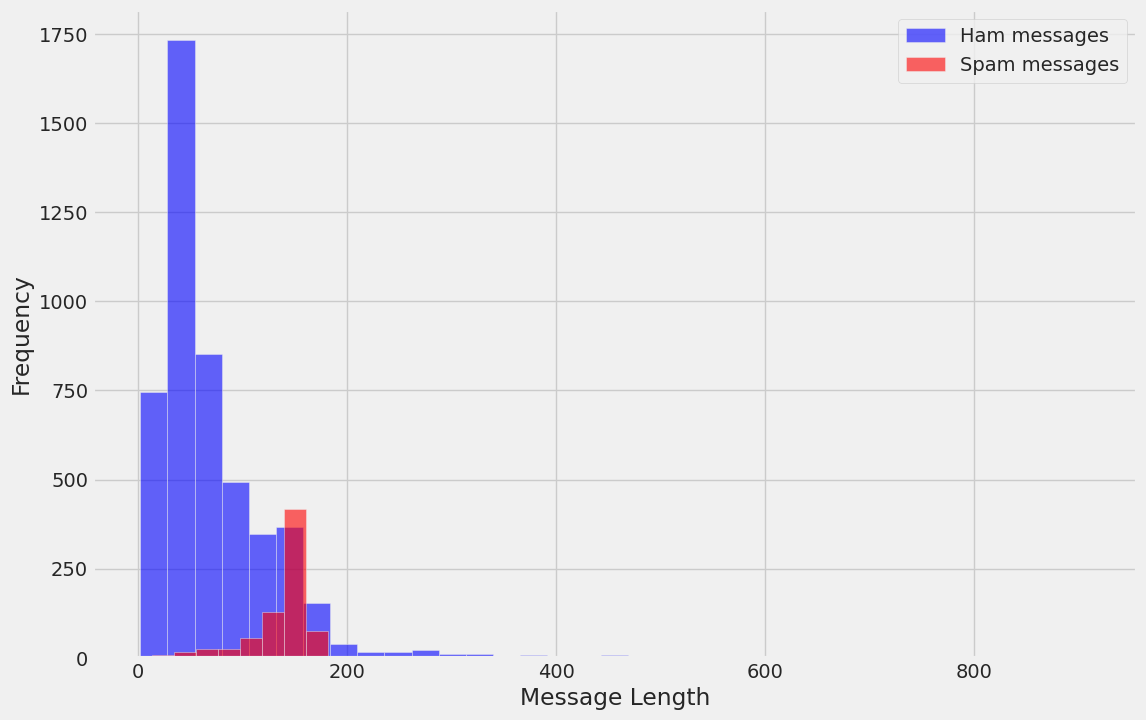

In [9]:
plt.figure(figsize=(12, 8))

sms_data[sms_data.label =='ham'].len_messages.plot(bins = 35,
                                                            kind = 'hist',
                                                            color = 'blue',
                                       label = 'Ham messages', alpha = 0.6)
sms_data[sms_data.label == 'spam'].len_messages.plot(kind = 'hist',
                                                             color = 'red', 
                                       label = 'Spam messages', alpha = 0.6)
plt.legend()
plt.xlabel("Message Length")

#### Dataset distribution by target

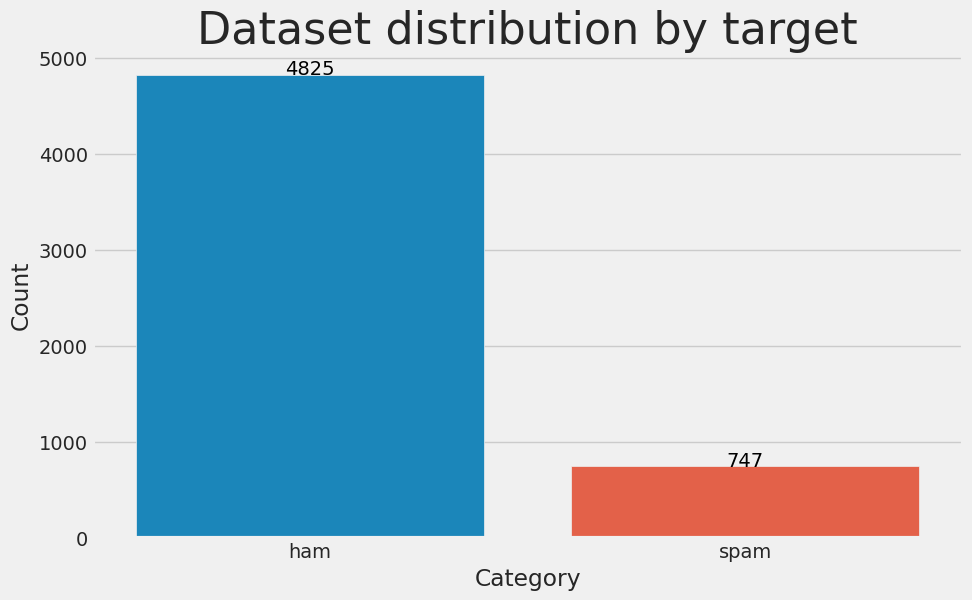

In [10]:
balance_counts = sms_data.groupby('label')['label'].agg('count').values

data = {
    'Category': ['ham', 'spam'],
    'Count': [balance_counts[0], balance_counts[1]]
}

df = pd.DataFrame(data)

plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Category', y = 'Count', data = df)

for index, row in df.iterrows():
    barplot.text(index, row.Count, row.Count, color = 'black', ha = "center")

plt.title('Dataset distribution by target', fontsize = 32, fontname = 'Times New Roman')
plt.show()

    As we can see, the classes are imbalanced, so we can consider using some kind of resampling. We will study later. Anyway, it doesn't seem to be necessary.

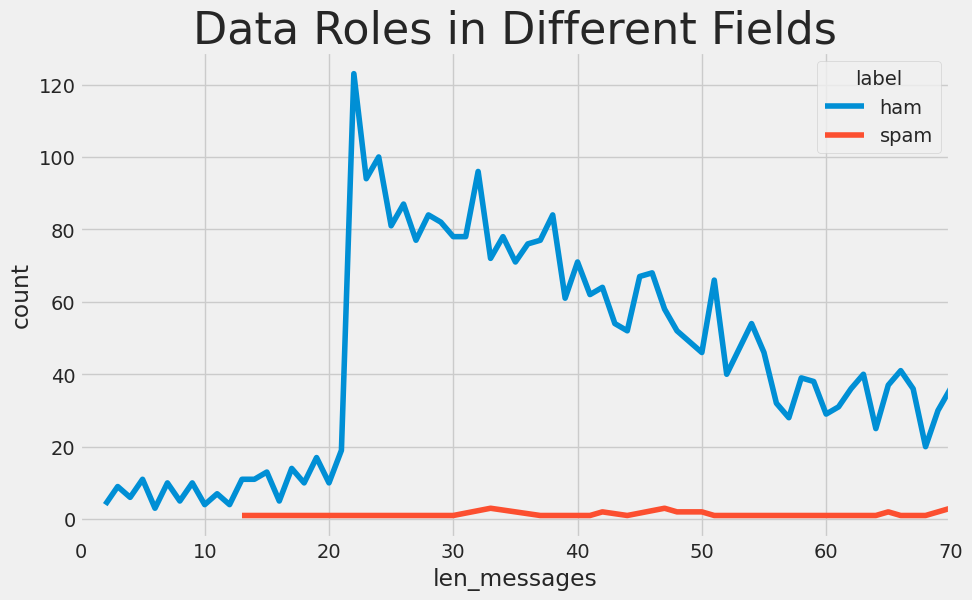

In [11]:
ham_df = sms_data[sms_data['label'] == 'ham']['len_messages'].value_counts().sort_index()
spam_df = sms_data[sms_data['label'] == 'spam']['len_messages'].value_counts().sort_index()

ham_data = pd.DataFrame({'len_messages': ham_df.index, 'count': ham_df.values, 'label': 'ham'})
spam_data = pd.DataFrame({'len_messages': spam_df.index, 'count': spam_df.values, 'label': 'spam'})

combined_df = pd.concat([ham_data, spam_data])

plt.figure(figsize = (10, 6))
sns.lineplot(data = combined_df, x = 'len_messages', y = 'count', hue = 'label')

plt.title('Data Roles in Different Fields', fontsize = 32, fontname = 'Times New Roman')
plt.xlim(0, 70)
plt.show()

    As we can see, the `ham` message length tend to be lower than `spam` message length.

<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        📊 Tokens Visualization
    </h3>
</div>


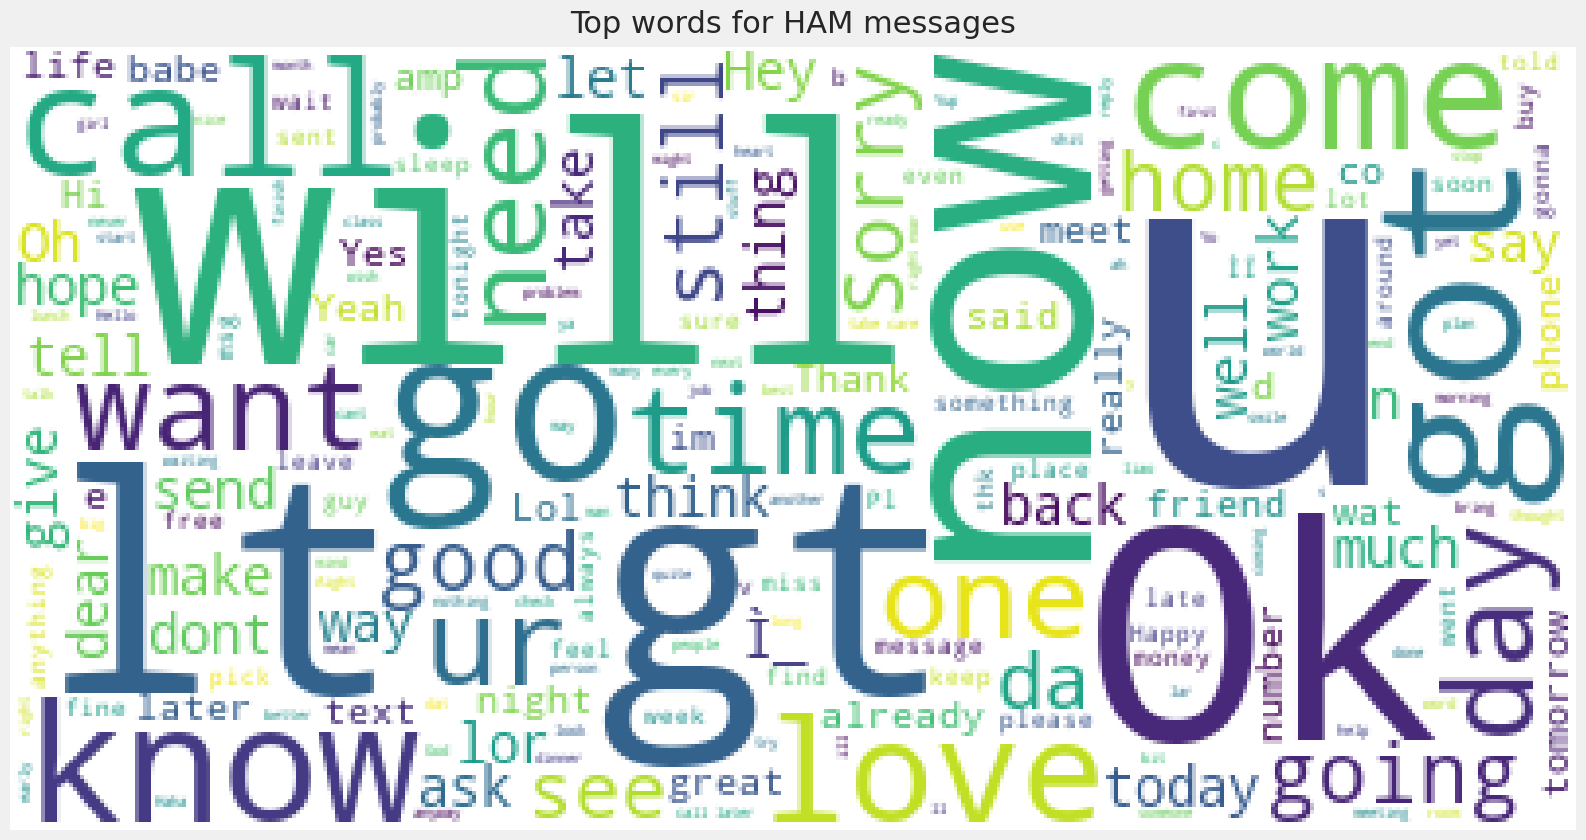

In [12]:
wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in sms_data.loc[sms_data['label'] == 'ham', 'message']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

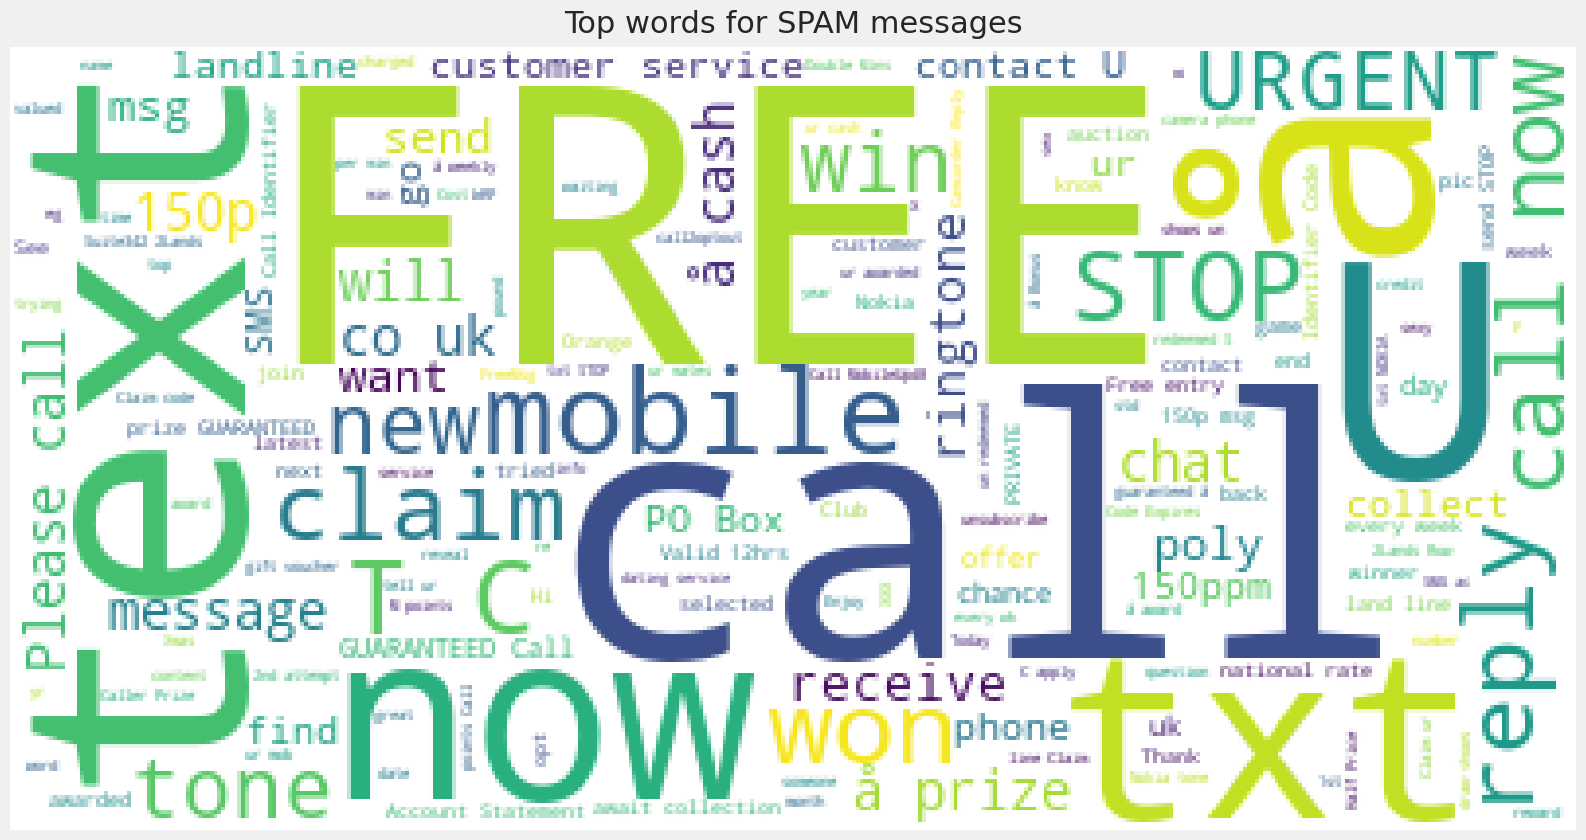

In [13]:
wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in sms_data.loc[sms_data['label'] == 'spam', 'message']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<div style="background-color:#34495E; padding:15px; border-radius:15px; margin-bottom:10px; text-align:center;">
    <h2 style="color:white; font-family:Arial; font-weight:bold;">
        📑 Text Pre-Processing
    </h2>
</div>


In [14]:
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers
    Remove all stopwords
    Returns a list of the cleaned text
    """
    text = str(mess).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    text = re.sub('\n', '', nopunc)
    text = re.sub('\w*\d\w*', '', text)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        Stemming
    </h3>
</div>


In [15]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        Apply All together
    </h3>
</div>


In [16]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = text_process(text)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [17]:
shuffled_data['cleaned_message'] = shuffled_data['message'].apply(preprocess_data)
shuffled_data.head()

,label,message,cleaned_message
3245,0,"Funny fact Nobody teaches volcanoes 2 erupt, t...",funni fact nobodi teach volcano erupt tsunami ...
944,0,I sent my scores to sophas and i had to do sec...,sent score sopha secondari applic school think...
1044,1,We know someone who you know that fancies you....,know someon know fanci call 09058097218 find p...
2484,0,Only if you promise your getting out as SOON a...,promis get soon youll text morn let know made ok
812,1,Congratulations ur awarded either å£500 of CD ...,congratul award either å£500 cd gift voucher f...


<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        🧮 Vectorization
    </h3>
</div>


In [18]:
from sklearn.model_selection import train_test_split
# split data first
X = shuffled_data.cleaned_message
y = shuffled_data.label
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify = y)
print(X_train.shape, y_train.shape)

(5169,) (5169,)
(3876,) (3876,)


In [19]:
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

# examine the document-term matrix
print(X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
print(X_test_dtm.shape)

(3876, 6646)
(1293, 6646)


In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 31218 stored elements and shape (3876, 6646)>

<div style="background-color:#34495E; padding:15px; border-radius:15px; margin-bottom:10px; text-align:center;">
    <h2 style="color:white; font-family:Arial; font-weight:bold;">
        🤖 Modeling
    </h2>
</div>


<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        🛟 Baseline Models
    </h3>
</div>


In [21]:
svc = SVC(kernel = 'sigmoid', gamma = 1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
dtc = DecisionTreeClassifier(max_depth = 5)
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators = 50, random_state = 2)
abc = AdaBoostClassifier(n_estimators = 50, random_state = 2)
bc = BaggingClassifier(n_estimators = 50, random_state = 2)
etc = ExtraTreesClassifier(n_estimators = 50, random_state = 2)
gbdt = GradientBoostingClassifier(n_estimators = 50,random_state = 2)
xgb = XGBClassifier(n_estimators = 50,random_state = 2)

clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'gnb': gnb,
    'bnb': bnb,
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

def train_and_evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test):
    
    # Convert sparse matrices to dense, if needed
    if hasattr(X_train, "toarray"):
        X_train = X_train.toarray()
    
    if hasattr(X_test, "toarray"):
        X_test = X_test.toarray()
        
    results = {}

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        
        # Predictions for training and test sets
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        # Calculate accuracies and precision
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred, average = 'weighted')  # Handle multi-class if needed
        
        # Store the results
        results[clf_name] = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'precision': precision
        }
    
    return results

In [22]:
results = train_and_evaluate_classifiers(clfs, X_train_dtm, y_train, X_test_dtm, y_test)

# To view the results
for clf_name, metrics in results.items():
    print(f"{clf_name} -> Train Accuracy: {metrics['train_accuracy']:.4f}, "
          f"Test Accuracy: {metrics['test_accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}")

SVC -> Train Accuracy: 0.9125, Test Accuracy: 0.9258, Precision: 0.9296
KN -> Train Accuracy: 0.9200, Test Accuracy: 0.9056, Precision: 0.9148
NB -> Train Accuracy: 0.9930, Test Accuracy: 0.9791, Precision: 0.9790
gnb -> Train Accuracy: 0.9417, Test Accuracy: 0.8708, Precision: 0.9212
bnb -> Train Accuracy: 0.9835, Test Accuracy: 0.9667, Precision: 0.9680
DT -> Train Accuracy: 0.9389, Test Accuracy: 0.9312, Precision: 0.9325
LR -> Train Accuracy: 0.9866, Test Accuracy: 0.9729, Precision: 0.9724
RF -> Train Accuracy: 0.9997, Test Accuracy: 0.9606, Precision: 0.9618
AdaBoost -> Train Accuracy: 0.9757, Test Accuracy: 0.9637, Precision: 0.9626
BgC -> Train Accuracy: 0.9990, Test Accuracy: 0.9621, Precision: 0.9614
ETC -> Train Accuracy: 1.0000, Test Accuracy: 0.9745, Precision: 0.9746
GBDT -> Train Accuracy: 0.9616, Test Accuracy: 0.9544, Precision: 0.9541
xgb -> Train Accuracy: 0.9837, Test Accuracy: 0.9706, Precision: 0.9702


In [23]:
performance_df1 = pd.DataFrame(results).T.sort_values('test_accuracy',ascending = False)
performance_df1

,train_accuracy,test_accuracy,precision
NB,0.993034,0.979118,0.978975
ETC,1.000000,0.974478,0.974559
LR,0.986584,0.972931,0.972419
xgb,0.983746,0.970611,0.970175
bnb,0.983488,0.966744,0.967963
AdaBoost,0.975748,0.963650,0.962644
BgC,0.998968,0.962104,0.961433
RF,0.999742,0.960557,0.961832
GBDT,0.961558,0.954370,0.954126
DT,0.938854,0.931168,0.932509


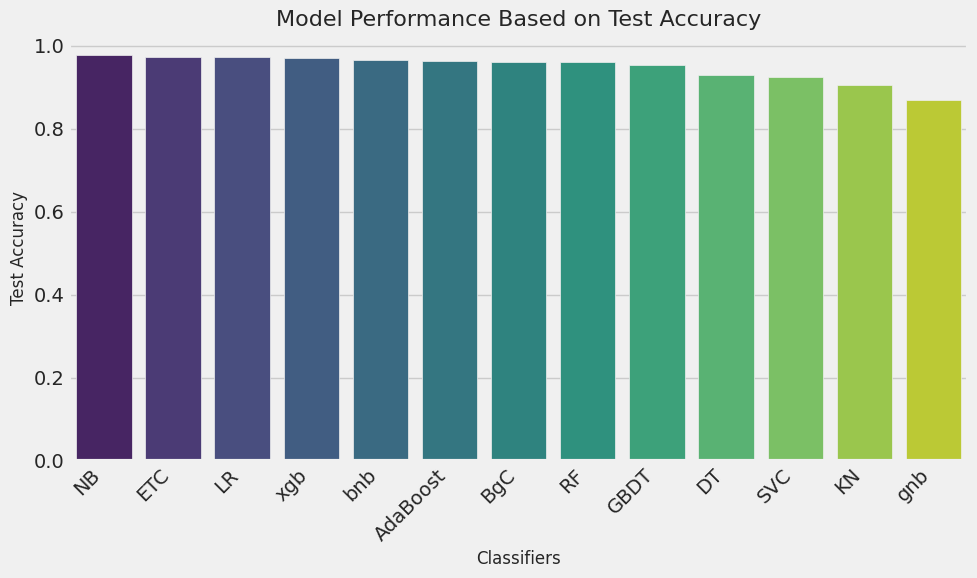

In [24]:
plt.figure(figsize = (10, 6))
sns.barplot(x = performance_df1.index, y = performance_df1['test_accuracy'], 
            palette = 'viridis')

# Add titles and labels
plt.title('Model Performance Based on Test Accuracy', fontsize = 16)
plt.xlabel('Classifiers', fontsize = 12)
plt.ylabel('Test Accuracy', fontsize = 12)

# Rotate x-axis labels for better readability
plt.xticks(rotation = 45, ha = 'right')

# Show plot
plt.tight_layout()
plt.show()

In [25]:
x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x = x_axes, y = y_axes):
    z = np.flip(z, 0)

    plt.figure(figsize = (10, 8))
    ax = sns.heatmap(z, annot = True, fmt = 'd', cmap = 'viridis',
                     xticklabels = x, yticklabels = y, cbar = True)

    ax.set_title('Confusion matrix', fontsize = 16, fontweight = 'bold')
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Real value')

    plt.show()

0.9791183294663574


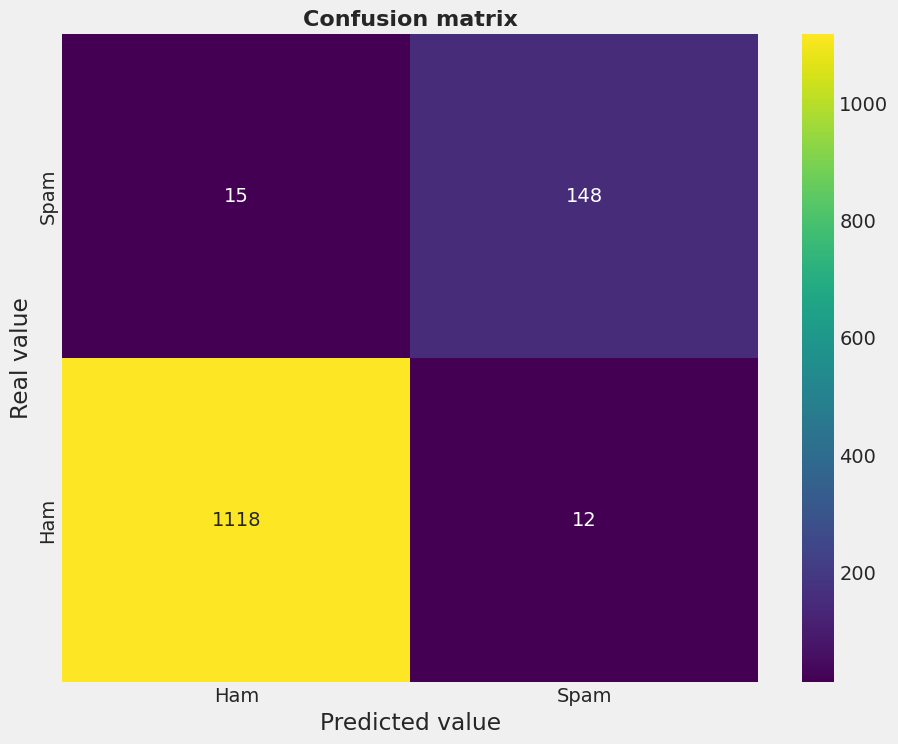

In [26]:
from sklearn.metrics import confusion_matrix
mnb = MultinomialNB()
mnb.fit(X_train_dtm, y_train)
        
# Predictions for training and test sets
y_test_pred = mnb.predict(X_test_dtm)

print(accuracy_score(y_test, y_test_pred))

conf_matrix(confusion_matrix(y_test, y_test_pred))

In [130]:
pipe = Pipeline([
    ('bow', CountVectorizer()),  
    ('model', MultinomialNB())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('model', MultinomialNB())])

In [ ]:
import pickle
pickle.dump(pipe,open('MultinomialNB_model.pkl','wb'))

<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        🛟 Apply Voting and Stacking
    </h3>
</div>


In [27]:
from sklearn.ensemble import VotingClassifier

mnb = MultinomialNB()
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
etc = ExtraTreesClassifier(n_estimators = 50, random_state=2)

voting = VotingClassifier(estimators=[('lrc', lrc), ('nb', mnb), ('et', etc)],voting = 'soft')

voting.fit(X_train_dtm, y_train)

VotingClassifier(estimators=[('lrc',
                              LogisticRegression(penalty='l1',
                                                 solver='liblinear')),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [28]:
# Predictions for training and test sets
y_test_pred = voting.predict(X_test_dtm)

print('Accuracy', accuracy_score(y_test, y_test_pred))
print("Precision", precision_score(y_test, y_test_pred))

Accuracy 0.979891724671307
Precision 0.9659863945578231


In [29]:
from sklearn.ensemble import StackingClassifier

estimators = [('lrc', lrc), ('nb', mnb), ('et', etc)]
final_estimator = XGBClassifier(n_estimators = 50,random_state = 2)

clf = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
clf.fit(X_train_dtm, y_train)

StackingClassifier(estimators=[('lrc',
                                LogisticRegression(penalty='l1',
                                                   solver='liblinear')),
                               ('nb', MultinomialNB()),
                               ('et',
                                ExtraTreesClassifier(n_estimators=50,
                                                     random_state=2))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=50, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=2, ...))

In [30]:
# Predictions for training and test sets
y_test_pred = clf.predict(X_test_dtm)

print('Accuracy', accuracy_score(y_test, y_test_pred))
print("Precision", precision_score(y_test, y_test_pred))

Accuracy 0.9806651198762568
Precision 0.9367088607594937


<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        💎 Fine Tune XGBoost
    </h3>
</div>


In [31]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate = 0.1,
        max_depth = 7,
        n_estimators = 80,
        use_label_encoder = False,
        eval_metric = 'auc',
    ))
])

# Fit the pipeline with the data
pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=80, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [32]:
y_pred_class = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

print('Train: {}'.format(accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(accuracy_score(y_test, y_pred_class)))

Train: 0.9803921568627451
Test: 0.9566898685228151


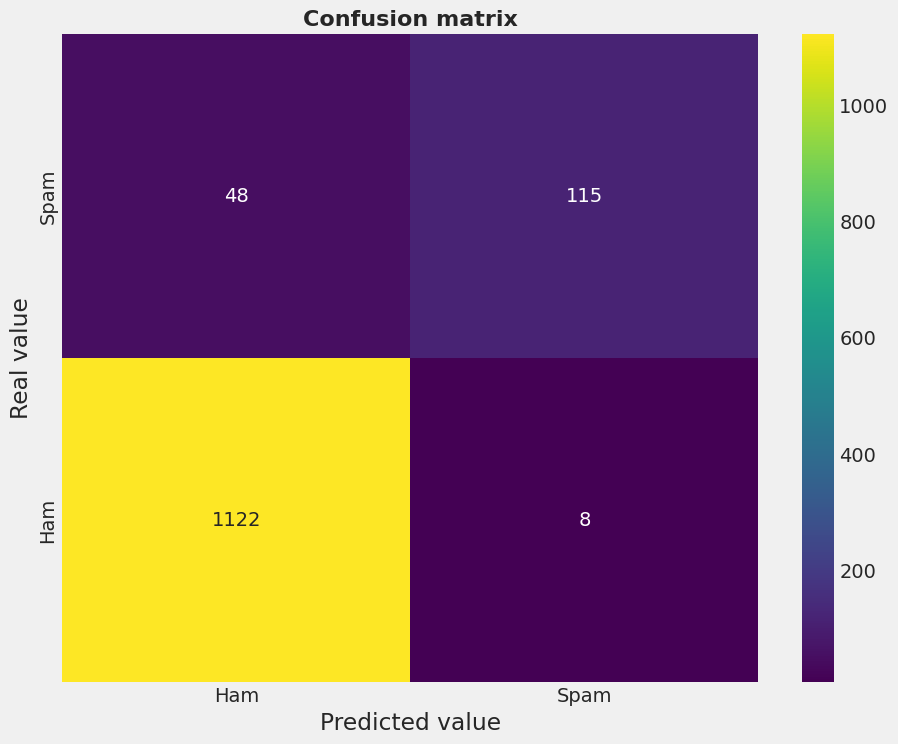

In [33]:
conf_matrix(confusion_matrix(y_test, y_pred_class))

#### **Note:** After evaluating all the baseline models, we observe that the Multinomial Naive Bayes (MultinomialNB) model outperforms the others. It demonstrates the highest accuracy, effectively classifies both ham and spam, and exhibits fewer errors according to the confusion matrix.


<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        Word Embeddings : GLOVE
    </h3>
</div>


In [35]:
# helper function
# ! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# glove embedding
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

# unzip folder
from helper_functions import unzip_data
unzip_data('glove.twitter.27B.zip')

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word2index = tokenizer.word_index

In [38]:
len(word2index)+1

6697

In [43]:
max_len = round(sum([len(i.split()) for i in X_train]) / len(X_train))
max_len

9

In [39]:
file = open('/kaggle/working/glove.twitter.27B.200d.txt', 'r', encoding = 'utf8')
content = file.readlines()
file.close()

embeddings = {}

for line in content:
    line = line.split()
    embeddings[line[0]] = np.array(line[1:], dtype = float)

embed_size = 200
embedding_matrix = np.zeros((len(word2index)+1, embed_size))

for word, i in word2index.items():
    embed_vector = embeddings.get(word) # Use get() to avoid KeyError
    if embed_vector is not None:
        embedding_matrix[i] = embed_vector
    else:
        embedding_matrix[i] = np.random.randn(embed_size) # Replace OOV with random vector

In [40]:
embedding_matrix.shape

(6697, 200)

In [71]:
# text vectorization
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = len(word2index) + 1,
                                    standardize = 'lower_and_strip_punctuation',
                                    split = 'whitespace',
                                    ngrams = None,
                                    output_mode = 'int',
                                    output_sequence_length = max_len)
text_vectorizer.adapt(X_train)

In [72]:
from tensorflow.keras.layers import Embedding
embedding_1 = Embedding(
        input_dim = len(word2index) + 1, 
        output_dim = embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length = max_len
    )

In [75]:
import random
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence
sample_embed = embedding_1(text_vectorizer([random_sentence]))
sample_embed

Original text:
get 3 lion england tone repli lionm mono lionp poli go origin n best tone 3gbp network oper rate appli      

Embedded version:


<tf.Tensor: shape=(1, 9, 200), dtype=float32, numpy=
array([[[-0.12612  , -0.048068 ,  0.63781  , ..., -0.19829  ,
          0.012291 , -0.18605  ],
        [ 0.753    , -0.70215  , -0.28245  , ...,  0.80497  ,
         -0.19024  , -0.16407  ],
        [-0.094054 ,  0.41888  ,  0.24063  , ..., -0.43334  ,
          0.30853  ,  0.22468  ],
        ...,
        [-0.028757 ,  0.016486 ,  0.1758   , ...,  0.069041 ,
         -0.23186  ,  0.01273  ],
        [ 0.15565  , -0.11024  ,  0.33201  , ...,  0.4385   ,
         -0.078137 ,  0.076379 ],
        [-0.48871  , -0.35623  ,  0.18943  , ...,  0.51568  ,
          0.28545  , -0.0075212]]], dtype=float32)>

<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        👌 Simple Dense Model
    </h3>
</div>


In [82]:
# Create a tensorboard callback (need to create a new one for each model)
import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(42)

model_1 = Sequential([
    layers.Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    embedding_1,
    layers.GlobalAveragePooling1D(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
], name = 'model_1_dense')

model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 9)              │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 9, 200)         │     1,339,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,373,449 (5.24 MB)

 Trainable params: 1,373,449 (5.24 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
Model_1_hist = model_1.fit(X_train,
                        y_train,
                        batch_size = 32,
                        epochs = 10,
                        validation_data = (X_test, y_test),
                        callbacks = [reduce_lr])

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8649 - loss: 0.2917 - val_accuracy: 0.9783 - val_loss: 0.0833 - learning_rate: 0.0010
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9964 - loss: 0.0139 - val_accuracy: 0.9745 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9768 - val_loss: 0.1124 - learning_rate: 0.0010
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 7.1124e-04 - val_accuracy: 0.9729 - val_loss: 0.1170 - learning_rate: 0.0010
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.6646e-04 - val_accuracy: 0.9729 - val_loss: 0.1230 - learning_rate: 0.0010
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.5062e-04 - val_accuracy: 0.9729 - val_loss: 0.1275 - learning_rate: 0.0010
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - los

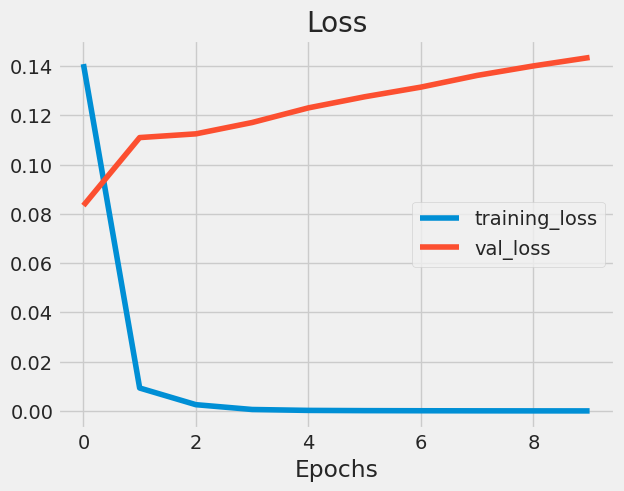

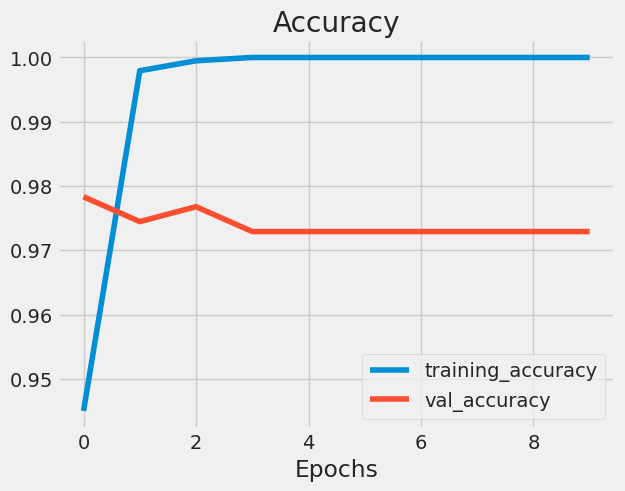

In [84]:
from helper_functions import plot_loss_curves
plot_loss_curves(Model_1_hist)

<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        👌 LSTM
    </h3>
</div>


In [90]:
tf.random.set_seed(42)

model_2_embedding = Embedding(
        input_dim = len(word2index) + 1, 
        output_dim = embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length = max_len
    )
model_2 = Sequential([
    layers.Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    model_2_embedding,
    layers.Bidirectional(LSTM(
        64, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )),
    layers.Dropout(0.5),
    layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True) ,
    layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2),
    Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
], name = 'model_2_LSTM')

model_2.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 9)              │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 9, 200)         │     1,339,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 9, 128)         │       135,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 9, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,574,153 (6.00 MB)

 Trainable params: 1,574,153 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
Model_2_hist = model_2.fit(X_train,
                        y_train,
                        batch_size = 32,
                        epochs = 10,
                        validation_data = (X_test, y_test))

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7453 - loss: 0.6101 - val_accuracy: 0.8739 - val_loss: 0.3761
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8679 - loss: 0.3631 - val_accuracy: 0.8794 - val_loss: 0.2439
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8914 - loss: 0.2297 - val_accuracy: 0.9312 - val_loss: 0.1988
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9385 - loss: 0.1761 - val_accuracy: 0.9490 - val_loss: 0.1639
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9515 - loss: 0.1347 - val_accuracy: 0.9482 - val_loss: 0.1462
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9670 - loss: 0.0990 - val_accuracy: 0.9536 - val_loss: 0.1406
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9732 - loss: 0.0830 - val_accuracy: 0.9528 - val_loss: 0.1414
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9787 - loss: 0.0755 - val_acc

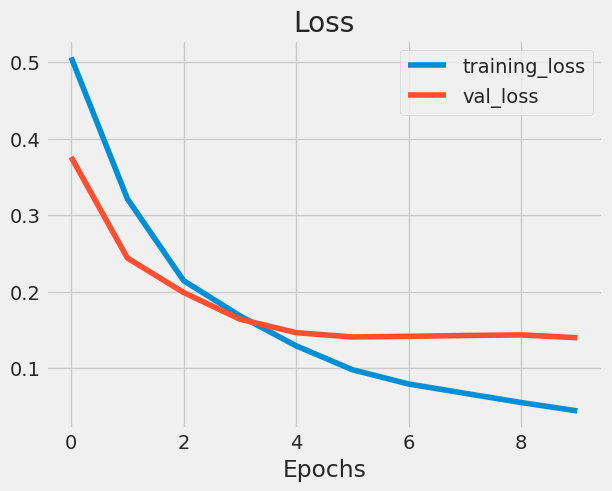

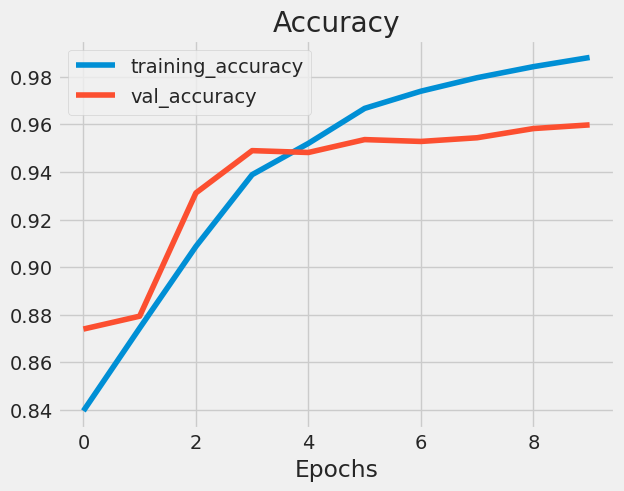

In [92]:
plot_loss_curves(Model_2_hist)

<div style="background-color:#9B59B6; padding:10px; border-radius:10px; margin-bottom:8px; text-align:center;">
    <h3 style="color:white; font-family:Arial; font-weight:bold; font-size:18px;">
        ♨️ Universal Sentence Encoder (Pretrained Model)
    </h3>
</div>


In [93]:
# function to get any model or preprocessor from tensorflow hub
import tensorflow_hub as hub
def get_tfhub_model(model_link, model_name, model_trainable = False):
    return hub.KerasLayer(model_link, 
                         trainable = model_trainable,
                         name = model_name, 
                         dtype = tf.string)

In [112]:
# get universal sentence encoder model
encoder_link = 'https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2'

encoder_name = 'universal_sentence_encoder'
encoder_trainable = True

encoder = get_tfhub_model(encoder_link, model_name = encoder_name, model_trainable = encoder_trainable)

In [118]:
# Build Model
def build_pretrained_model():
    initializer = tf.keras.initializers.HeNormal(seed = 42)
    
    message_input = layers.Input(shape = (), dtype = tf.string)
    
    mess_embedding = layers.Lambda(lambda x: encoder(x), output_shape = (512,))(message_input)
    
    expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis = 1))(mess_embedding)
    bi_lstm = layers.Bidirectional(layers.LSTM(128, kernel_initializer = initializer), 
                                   name = 'bidirection_lstm')(expand_layer)
    
    dropout_layer = layers.Dropout(0.25)(bi_lstm)
    dense_layer = layers.Dense(128, activation = 'relu', kernel_initializer = initializer)(dropout_layer)
    output_layer = layers.Dense(1, activation='sigmoid', 
                                kernel_initializer = initializer, 
                                name = 'output_layer')(dense_layer)
    
    return tf.keras.Model(inputs = [message_input], 
                          outputs = [output_layer], 
                          name = 'use_model')

In [119]:
model_use = build_pretrained_model()
model.summary()

Model: "use_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirection_lstm                │ (None, 256)            │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,409 (2.63 MB)

 Trainable params: 689,409 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
# define callbacks and metrics for training the model
checkpoint_path = "USE_Model.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only = True,
    save_weights_only = True,
    monitor = "val_accuracy",
    verbose = 1
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 10, 
    restore_best_weights = True)

CALLBACKS = [early_stopping_callback, checkpoint_callback]
METRICS = ['accuracy']

In [122]:
# function to train the model
def train_model(model, num_epochs, callbacks_list, train_data, train_target, valid_data = None, shuffling = False):
    model_history = {}
    
    if valid_data != None:
        model_history = model.fit(train_data,
                                  train_target,
                                  epochs = num_epochs,
                                  batch_size = 32,
                                  validation_data = valid_data,
                                  callbacks = callbacks_list,
                                  shuffle = shuffling)
    if valid_data == None:
        model_history = model.fit(train_data,
                                  train_target,
                                  epochs = num_epochs,
                                  callbacks = callbacks_list,
                                  shuffle = shuffling)
    return model_history

In [123]:
# compile and train the USE Model
tf.random.set_seed(42)

model_use.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = METRICS
)

model_history = train_model(
    model_use, 50, CALLBACKS, 
    train_data = X_train,
    train_target = y_train,
    valid_data = (X_test, y_test),
    shuffling = False
) 

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8785 - loss: 0.3763
Epoch 1: val_accuracy improved from -inf to 0.96752, saving model to USE_Model.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8789 - loss: 0.3750 - val_accuracy: 0.9675 - val_loss: 0.0906
Epoch 2/50
117/122 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9772 - loss: 0.0658
Epoch 2: val_accuracy did not improve from 0.96752
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9771 - loss: 0.0661 - val_accuracy: 0.9637 - val_loss: 0.0907
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9800 - loss: 0.0538
Epoch 3: val_accuracy did not improve from 0.96752
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9800 - loss: 0.0538 - val_accuracy: 0.9652 - val_loss: 0.0929
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9837 - loss: 0.0461
Epoch 4: val_accuracy did not improve from 0.96752
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0

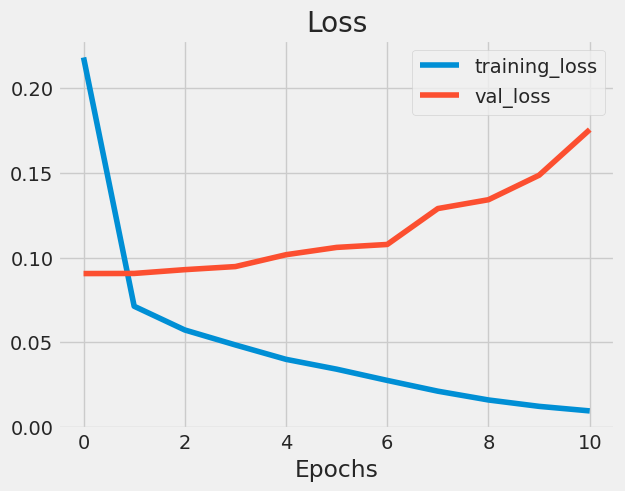

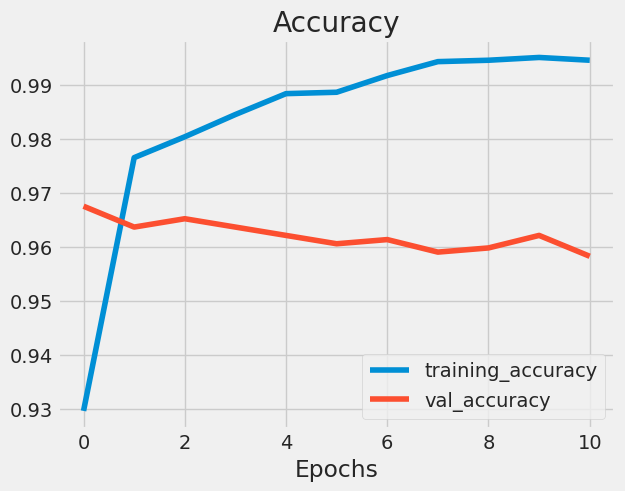

In [124]:
plot_loss_curves(model_history)

### Conclusion

In this notebook, we worked on text classification using deep learning. Here are some key points to improve the model:

1. **Use BERT for Features**: BERT (Bidirectional Encoder Representations from Transformers) can provide better text features, leading to improved model performance compared to basic embeddings.

2. **Try Transformers**: Using transformer models like BERT or GPT can improve results. They are very powerful for text-related tasks.

3. **Fix Class Imbalance**: The dataset is imbalanced between 'spam' and 'ham'. To fix this:
   - Add more data for the 'spam' class or balance the classes by resampling.
   - Use techniques like SMOTE to generate synthetic data.
   - Adjust class weights in the model.

4. **Get More Data**: More labeled data for both classes (spam and ham) will improve model accuracy and make it more reliable.

By implementing these improvements, the model can perform better in classifying spam and ham messages.